In [1]:
#para apagar diretório de modelos quando for gerar novos modelos
#import shutil
#diretorio_a_apagar = './AutogluonModels'
#shutil.rmtree(diretorio_a_apagar)

In [2]:
#para executar esse projeto é necessário ter a seguintes libs instaladas
#pip install pandas
#pip install scipy
#pip install autogluon
#pip install opendatasets --upgrade
#pip install -U imbalanced-learn
#pip install neurokit2

In [3]:
#libs "básicas"
import os
import csv
import numpy as np
import pandas as pd
import neurokit2 as nk
from scipy import stats
import matplotlib.pyplot as plt

#libs que auxiliam os modelos
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#lib para importar base de dados
import opendatasets as od

A base de dados é oficialmente compartilhada pela [PhysioNet](https://www.physionet.org/content/mitdb/1.0.0/), porém, executando a linha a seguir, a mesma base de dados é obtida através da plataforma kaggle com auxílio da biblioteca opendatasets.

In [4]:
od.download("https://www.kaggle.com/datasets/taejoongyoon/mitbit-arrhythmia-database?datasetId=52320&sortBy=voteCount")

Skipping, found downloaded files in "./mitbit-arrhythmia-database" (use force=True to force download)


## Pré processamento
Iremos analisar os modelos com dados sem remoção de ruído e com remoção de ruído

#### Variáveis auxiliares

In [5]:
path = './mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'a', 'J', 'V', 'F', '!', 'e', 'j', 'E', '/', 'f', 'x', '|']
n_classes = len(classes)
count_classes = {elemento: 0 for elemento in classes}

X = list()
y = list()

In [6]:
description_beats = {'N':'Batida normal', 'L':'Batida de bloqueio de ramo esquerdo',
                     'R':'Batida de bloqueio de ramo direito','A':'Batimento atrial prematuro',
                     'a':'Batimento atrial prematuro aberrado','J':'Batimento prematuro nodal (juncional)',
                     'S':'Batimento supraventricular prematuro ou ectópico (atrial ou nodal)',
                     'V':'Contração ventricular prematura','F':'Fusão de batimento ventricular e normal',
                     'e':'Batida de escape atrial','j':'Batida de escape nodal (juncional)',
                     'E':'Batida de escape ventricular','/':'Batida ritmada',
                     'f':'Fusão de batida ritmada e normal','Q': 'Batida inclassificável'}

#### Preparo dos arquivos

In [7]:
# Leitura dos arquivos
filenames = next(os.walk(path))[2]

# Para separar e salvar os arquivos em csv e txt
records = list()
annotations = list()
filenames.sort()

In [8]:
# Definindo nomes de arquivos e anotações
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)

In [9]:
len(records), len(annotations)

(48, 48)

#### Extração dos dados e pré processamento sem remoção de rúido

In [10]:
%%time
# Registros
X_with_noise = list() #x contém os valores do sinais
y_with_noise = list() #y para os rótulos
z_with_noise = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
                
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X_with_noise.append(beat)
                    y_with_noise.append(arrhythmia_index)
                    z_with_noise.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X_with_noise), np.shape(y_with_noise))

(110200, 360) (110200,)
CPU times: user 19.5 s, sys: 635 ms, total: 20.1 s
Wall time: 20.1 s


Utilizamos a coluna ``record_id`` afim de facilitar consultas relacionadas a qual registro pertence cada linha em casos de dúvidas, mas a coluna não é utilizada nos modelos.

In [11]:
noisy_database = pd.DataFrame(data=X_with_noise)
noisy_database['label'] = y_with_noise
noisy_database['record_id'] = z_with_noise
noisy_database.head()

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,label,record_id
0,-0.148556,-0.174436,-0.045036,0.032603,0.032603,0.084363,0.058483,0.084363,0.110243,0.162003,...,-0.122676,-0.122676,-0.200316,-0.200316,-0.200316,-0.070916,-0.122676,-0.148556,0,100
1,-0.329716,-0.303836,-0.277956,-0.303836,-0.174436,-0.096796,-0.045036,-0.070916,-0.122676,-0.122676,...,-0.329716,-0.277956,-0.303836,-0.277956,-0.303836,-0.381476,-0.329716,-0.303836,0,100
2,-0.433236,-0.355596,-0.277956,-0.174436,-0.148556,-0.122676,-0.148556,-0.148556,-0.096796,-0.070916,...,-0.148556,-0.122676,-0.148556,-0.174436,-0.148556,-0.070916,-0.174436,-0.174436,0,100
3,-0.070916,-0.045036,-0.070916,-0.096796,-0.045036,0.058483,0.110243,0.032603,0.058483,0.110243,...,-0.122676,-0.070916,-0.045036,-0.096796,-0.148556,-0.252076,-0.200316,-0.174436,0,100
4,-0.614396,-0.588516,-0.510876,-0.381476,-0.329716,-0.303836,-0.303836,-0.303836,-0.200316,-0.122676,...,-0.019156,-0.019156,-0.122676,-0.148556,-0.122676,-0.070916,-0.096796,-0.096796,0,100


In [12]:
noisy_database.shape

(110200, 362)

In [13]:
noisy_database['label'].value_counts()

0     75011
1      8071
2      7255
6      7129
12     7023
3      2546
13      982
7       802
8       472
10      229
14      193
4       150
15      132
11      106
5        83
9        16
Name: label, dtype: int64

#### Extração dos dados e pré processamento com remoção de rúido

O parâmetro de taxa de amostragem (sampling rate) ideal pode depender da frequência de amostragem original dos seus dados. O ideal é que a taxa de amostragem seja preservada durante todo o processamento para evitar perda de informações importantes.

In [14]:
def denoise(ecg): 
    #sampling_rate ( int ) – A frequência de amostragem do sinal (em Hz, ou seja, amostras/segundo).
    data = nk.ecg_clean(ecg, sampling_rate=360, method="neurokit")     
    return data

In [15]:
%%time
# Registros
X = list() #x contém os valores do sinais
y = list() #y para os rótulos
Z = list() #z indica o índice do registro

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # ler arquivo csv
        next(spamreader) # ignora header
        for row in spamreader:
            signals.append(int(row[1]))
            
    signals = denoise(signals)
    
    # Normalizando os dados: https://www.investopedia.com/terms/z/zscore.asp
    signals = stats.zscore(signals)
    
    
    with open(annotations[r], 'r') as fileID:
        lines = fileID.readlines()[1:] # 0 índice é o cabeçalho do gráfico, ignora o header

        for line in lines:
            row = list(filter(lambda item: item != '', line.split(' ')))
            time, sample, arrhythmia_type = row[0:3]
            pos = int(sample)

            if(arrhythmia_type in classes): # Verificar se é uma classe válida
                # Contar a quantidade de dados de cada classe
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_type] += 1
                
                # pos é o momento que foi feita a analise.
                if(window_size <= pos and (pos + window_size) < len(signals)):
                    # pega uma janela de tempo onde o pos fica no meio
                    beat = signals[pos-window_size:pos+window_size]
        
                    X.append(beat)
                    y.append(arrhythmia_index)
                    Z.append(os.path.splitext(os.path.basename(records[r]))[0])

print(np.shape(X), np.shape(y))

(110200, 360) (110200,)
CPU times: user 19.4 s, sys: 680 ms, total: 20 s
Wall time: 20 s


In [16]:
database = pd.DataFrame(data=X)
database['label'] = y
database['record_id'] = Z
database.head()

,0,1,2,3,4,5,6,7,8,9,...,352,353,354,355,356,357,358,359,label,record_id
0,-0.360519,-0.319990,-0.275334,-0.232754,-0.191561,-0.147619,-0.102996,-0.058381,-0.015153,0.025999,...,-0.016707,-0.015152,-0.014977,-0.013427,-0.010500,-0.006197,-0.006722,-0.008627,0,100
1,-0.347760,-0.272265,-0.202976,-0.140584,-0.081642,-0.032352,0.008663,0.040714,0.065870,0.087576,...,-0.200547,-0.204075,-0.206914,-0.205619,-0.202256,-0.197516,-0.189329,-0.179076,0,100
2,-0.304913,-0.242247,-0.178891,-0.118982,-0.065966,-0.019842,0.019389,0.053796,0.084756,0.112269,...,-0.028826,-0.022611,-0.019841,-0.022584,-0.029461,-0.039095,-0.054930,-0.071454,0,100
3,-0.001562,0.043882,0.084502,0.123744,0.162298,0.197407,0.228382,0.253154,0.276549,0.297188,...,0.016617,0.015064,0.010063,0.002304,-0.006148,-0.015980,-0.019611,-0.018420,0,100
4,-0.531150,-0.482258,-0.426476,-0.366560,-0.306646,-0.246045,-0.184756,-0.123468,-0.062872,-0.007791,...,-0.036881,-0.042875,-0.053003,-0.061751,-0.069119,-0.075795,-0.083159,-0.087765,0,100


**Comparação dos tipos de batidas com e sem ruído**

### Análise dos dados
Nessa análise não importa se a base de dados é ``noisy_database`` ou ``database`` porque estamos analisando a quantidade de classes e não a qualidade do sinal.

In [17]:
database.dtypes.value_counts()

float64    360
int64        1
object       1
dtype: int64

In [139]:
database['label'].value_counts()

0     75011
1      8071
2      7255
6      7129
12     7023
3      2546
13      982
7       802
8       472
10      229
14      193
4       150
15      132
11      106
5        83
9        16
Name: label, dtype: int64

In [154]:
mapX = {'N': 75011, 'L': 8071,'R': 7255,'V': 7129, '/': 7023, 'A': 2546, 'f': 982, 'F': 802,'!': 472,'j': 229, 
        'x': 193,'a': 150,'|':132,'E': 106,'J': 83,'e': 16}

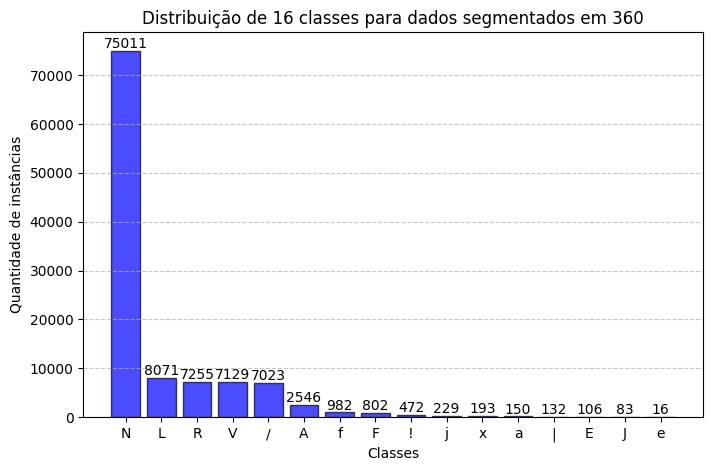

In [162]:
categorias = list(mapX.keys())
valores = list(mapX.values())

plt.figure(figsize=(8, 5))
plt.bar(categorias, valores, color='blue', edgecolor='black', alpha=0.7)

# Adicionar rótulos e título
plt.xlabel('Classes')
plt.ylabel('Quantidade de instâncias')
plt.title('Distribuição de 16 classes para dados segmentados em 360')

# Adicionar grades ao eixo y
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adicionar anotações (opcional)
for i, v in enumerate(valores):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom')
    
plt.savefig('distribuicao2.pdf')

# Exibir o gráfico
plt.show()

## AutoML com sinais ruidosos

In [20]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
noisy_database2 = noisy_database.iloc[:, :-1]
train_data, test_data = train_test_split(noisy_database2, random_state=42, stratify=noisy_database2.label)
train_data.shape, test_data.shape 

((82650, 361), (27550, 361))

In [21]:
X_train, y_train = train_data.iloc[:,:-1], train_data['label']
X_test, y_test = test_data.iloc[:,:-1], test_data['label']
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((82650, 360), (27550, 360), (82650,), (27550,))

In [22]:
%%time
predictor = TabularPredictor(label='label').fit(train_data, time_limit=7200, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/87e19736 ...
	0.9888	 = Validation score   (accuracy)
	181.3s	 = Training   runtime
	0.18s	 = Validation runtime
Fitted model: NeuralNetTorch/047a4968 ...
	0.951	 = Validation score   (accuracy)
	147.65s	 = Training   runtime
	0.2s	 = Validation runtime
Fitted model: NeuralNetTorch/e03a1bca ...
	0.8756	 = Validation score   (accuracy)
	254.41s	 = Training   runtime
	0.61s	 = Validation runtime
Fitted model: NeuralNetTorch/bd4a9e75 ...
	0.9906	 = Validation score   (accuracy)
	211.66s	 = Training   runtime
	0.17s	 = Validation runtime
Fitted model: NeuralNetTorch/6a521c20 ...
	0.8806	 = Validation score   (accuracy)
	491.56s	 = Training   runtime
	2.33s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 498.3s of the 4529.81s of remaining time.
	0.977	 = Validation score   (accuracy)
	389.99s	 = Training   runtime
	1.54s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.76s of the 4125.35s 

CPU times: user 4h 13min 50s, sys: 1min 4s, total: 4h 14min 54s
Wall time: 51min 17s


### Dataframe de hiperparâmetros

Iremos usar 3 métodos para os modelos do AutoGluon, o primeiro sem reamostragem, o segundo utilizando a técnica de reamostragem SMOTE e o terceiro a técnica de reamostragem ADASYN. Por isso, para auxiliar o acesso dos hiperparâmetros utilizaremos um dataframe.

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [23]:
def autogluon_models_df(window, filter_applied, resampling_tech, predictor_model, test_data_):
    leaderboard = predictor_model.leaderboard(test_data_, silent=True, extra_metrics=['accuracy','precision_weighted','recall_weighted', 'f1_weighted'])
    all_models = predictor_model.get_model_names()
    predictor_information = predictor_model.info()
    autogluon_accuracy = []
    autogluon_precision = []
    autogluon_f1 = []
    autogluon_recall = []
    autogluon_hyperparameters = []
    autogluon_algorithms = [] 
    for model in all_models:
        if model != 'WeightedEnsemble_L2':
            autogluon_algorithms.append(model)
            accuracy = (leaderboard.accuracy[leaderboard['model'] == model]).values[0]
            precision_weighted = (leaderboard.precision_weighted[leaderboard['model'] == model]).values[0]
            recall_weighted = (leaderboard.recall_weighted[leaderboard['model'] == model]).values[0]
            f1_weighted = (leaderboard.f1_weighted[leaderboard['model'] == model]).values[0]
            
            autogluon_accuracy.append(accuracy)
            autogluon_precision.append(precision_weighted)
            autogluon_recall.append(recall_weighted)
            autogluon_f1.append(f1_weighted)
            
            autogluon_hyperparameters.append(predictor_information["model_info"][model]["hyperparameters"])
            
    window_size_list = [window*2]*len(autogluon_algorithms)
    filter_applied_list = [filter_applied]*len(autogluon_algorithms)
    resampling_tech_list = [resampling_tech]*len(autogluon_algorithms)
        
    
    autogluon_args = list(zip(window_size_list, filter_applied_list, resampling_tech_list, 
                              autogluon_algorithms, autogluon_hyperparameters, autogluon_accuracy,
                             autogluon_precision, autogluon_recall, autogluon_f1))    
    
    hyperparameters = pd.DataFrame(autogluon_args, columns=['window_size','filter_applied','resampling_tech',
                                                            'model','hyperparameters','accuracy',
                                                            'precision_weighted','recall_weighted', 'f1_weighted'])
    
    hyperparameters = hyperparameters.sort_values(by='accuracy', ascending=False)
    hyperparameters = hyperparameters.reset_index(drop=True)
    
    #agrupamento por algoritmos
    hyperparameters['algorithm'] = ''
    all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
    
    hyperparameters.loc[hyperparameters['model'].str.contains('LightGBM'), 'algorithm'] = 'LightGBM'
    hyperparameters.loc[hyperparameters['model'].str.contains('RandomForest'), 'algorithm'] = 'RandomForest'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetTorch'), 'algorithm'] = 'NeuralNetTorch'
    hyperparameters.loc[hyperparameters['model'].str.contains('NeuralNetFastAI'), 'algorithm'] = 'NeuralNetFastAI'
    hyperparameters.loc[hyperparameters['model'].str.contains('XGBoost'), 'algorithm'] = 'XGBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('ExtraTrees'), 'algorithm'] = 'ExtraTrees'
    hyperparameters.loc[hyperparameters['model'].str.contains('CatBoost'), 'algorithm'] = 'CatBoost'
    hyperparameters.loc[hyperparameters['model'].str.contains('KNeighbors'), 'algorithm'] = 'KNeighbors'
    
    return hyperparameters

In [24]:
%%time
model_without_resampling = autogluon_models_df(window=window_size,
                                               filter_applied=False, 
                                               resampling_tech=None,
                                               predictor_model=predictor,
                                               test_data_=test_data)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.u

CPU times: user 7min 35s, sys: 2.56 s, total: 7min 38s
Wall time: 1min 10s


**Ranking dos modelos sem reamostragem e sem filtro**

In [25]:
model_without_resampling.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
1,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [164]:
z = 1.96
f1 = 0.9881
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9868195306126069, 0.9893804693873931)


In [27]:
model_without_resampling['algorithm'].value_counts()

LightGBM           7
NeuralNetFastAI    5
NeuralNetTorch     5
KNeighbors         2
RandomForest       2
ExtraTrees         2
XGBoost            1
CatBoost           1
Name: algorithm, dtype: int64

In [28]:
model_without_resampling['algorithm'].value_counts().sum()

25

Para evitar perda dos dados

In [29]:
model_without_resampling.to_csv('model_without_resampling.csv', index=False)

### AutoML com técnica de reamostragem SMOTE

In [30]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote = SMOTE(sampling_strategy='auto')

In [31]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62, 9: 12})


In [32]:
%%time
X_resampled_smote, y_resampled_smote = smote.fit_resample(X_train, y_train)

CPU times: user 16.1 s, sys: 1.77 s, total: 17.8 s
Wall time: 8.56 s


In [33]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote))

Distribuição de classes após a reamostragem:  Counter({0: 56258, 12: 56258, 13: 56258, 1: 56258, 6: 56258, 4: 56258, 2: 56258, 7: 56258, 3: 56258, 11: 56258, 8: 56258, 10: 56258, 14: 56258, 15: 56258, 5: 56258, 9: 56258})


In [34]:
resampled_smote = X_resampled_smote.join(y_resampled_smote)
resampled_smote.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,label
0,-0.377484,-0.352075,-0.352075,-0.352075,-0.326666,-0.275848,-0.301257,-0.301257,-0.275848,-0.326666,...,-0.123393,-0.123393,-0.021756,0.003653,0.054472,0.003653,0.029062,0.003653,0.029062,0
1,-0.002746,0.003082,-0.031882,-0.037709,-0.061018,-0.066846,-0.084327,-0.084327,-0.101809,-0.113464,...,0.014736,-0.002746,0.003082,0.008909,0.003082,-0.008573,-0.008573,-0.020227,0.003082,12
2,-0.105585,-0.062279,-0.105585,-0.148891,-0.134456,-0.091150,-0.076715,-0.018974,-0.033409,-0.091150,...,-0.307678,-0.033409,0.255296,0.673917,1.020363,1.294632,1.713254,2.160746,2.637109,0
3,-0.236055,-0.222389,-0.222389,-0.167722,-0.167722,-0.181389,-0.208722,-0.167722,-0.113055,-0.044722,...,-0.413722,-0.441056,-0.413722,-0.290722,-0.208722,-0.181389,-0.126722,-0.181389,-0.181389,0
4,-0.057805,-0.082375,-0.143799,-0.143799,-0.119229,-0.082375,-0.070090,-0.008666,-0.008666,-0.008666,...,0.126467,0.163322,0.224746,0.224746,0.273885,0.261600,0.249316,0.200176,0.138752,0


In [35]:
%%time
smote_resampling_training = TabularPredictor(label='label').fit(resampled_smote, time_limit=7200, 
                                                                hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

2023-12-03 02:08:25,953	ERROR trial_runner.py:1062 -- Trial cdfca6f0: Error processing event.
ray.tune.error._TuneNoNextExecutorEventError: Traceback (most recent call last):
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/tune/execution/ray_trial_executor.py", line 1276, in get_next_executor_event
    future_result = ray.get(ready_future)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/worker.py", line 2382, in get
    raise value
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.102.21.240, ID: aab385690118dd7c0659c694adf563c98c005fed3aae68e3a1c9a922) where the task (actor ID: 6593206f3c2ec8b621fa364101000000, name=ImplicitFunc.__init__, pid=600569, memory used=8.74GB) was running was 89.58GB

CPU times: user 3min 30s, sys: 36.6 s, total: 4min 7s
Wall time: 11min 57s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [36]:
%%time
models_with_smote = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training,
                                        test_data_=test_data)

CPU times: user 2.61 s, sys: 109 ms, total: 2.72 s
Wall time: 2.01 s


**Ranking dos modelos com a técnica de reamostragem SMOTE e sem filtro**

In [166]:
models_with_smote.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,smote,NeuralNetTorch/ea22e3e6,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 0.7, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.025397221831731192, 'weight_decay': 0.0018135762094857264, 'proc.embed_min_categories': 10, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 500, 'proc.skew_threshold': 0.5, 'use_ngram_features': False, 'num_layers': 4, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}",0.577278,0.88631,0.577278,0.669669,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [169]:
z = 1.96
f1 = 0.6696
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.6640457808488418, 0.6751542191511581)


In [39]:
models_with_smote['algorithm'].value_counts()

NeuralNetTorch    1
Name: algorithm, dtype: int64

In [40]:
models_with_smote['algorithm'].value_counts().sum()

1

Para evitar perda dos dados

In [41]:
models_with_smote.to_csv('models_with_smote.csv', index=False)

**Junção dos modelos**

In [42]:
hyperparameters_all_models = pd.concat([models_with_smote, model_without_resampling])

In [43]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [44]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [45]:
hyperparameters_all_models.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
1,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI


### AutoML com técnica de reamostragem ADASYN

In [46]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62, 9: 12})


In [47]:
adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn, y_resampled_adasyn = adasyn.fit_resample(X_train, y_train)

In [48]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn))

Distribuição de classes após a reamostragem:  Counter({9: 56262, 0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62})


In [49]:
resampled_adasyn = X_resampled_adasyn.join(y_resampled_adasyn)

In [50]:
%%time
adasyn_resampling_training = TabularPredictor(label='label').fit(resampled_adasyn, time_limit=7200,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/db013e75 ...
	0.9928	 = Validation score   (accuracy)
	144.08s	 = Training   runtime
	0.26s	 = Validation runtime
Fitted model: NeuralNetTorch/fa4065ea ...
	0.9942	 = Validation score   (accuracy)
	487.98s	 = Training   runtime
	0.21s	 = Validation runtime
Fitted model: NeuralNetTorch/4321f039 ...
	0.9662	 = Validation score   (accuracy)
	468.53s	 = Training   runtime
	2.22s	 = Validation runtime
Fitted model: NeuralNetTorch/558e0ece ...
	0.9924	 = Validation score   (accuracy)
	348.42s	 = Training   runtime
	0.1s	 = Validation runtime
Fitted model: NeuralNetTorch/3da6286e ...
	0.985	 = Validation score   (accuracy)
	471.7s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 498.14s of the 3707.19s of remaining time.
	0.9838	 = Validation score   (accuracy)
	499.0s	 = Training   runtime
	1.43s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.54s of the 3192.17s 

CPU times: user 6h 7min 47s, sys: 1min 24s, total: 6h 9min 12s
Wall time: 1h 6min 51s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [51]:
%%time
models_with_adasyn = autogluon_models_df(window=window_size,
                                        filter_applied=False, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training,
                                        test_data_=test_data)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.u

CPU times: user 9min 10s, sys: 3.02 s, total: 9min 13s
Wall time: 1min 16s


**Ranking dos modelos com a técnica de reamostragem ADASYN e sem filtro**

In [52]:
models_with_adasyn.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
1,360,False,adasyn,NeuralNetFastAI/65bbd68c,"{'layers': (500, 200), 'emb_drop': 0.03117924504700692, 'ps': 0.36490445895396484, 'bs': 128, 'lr': 0.0034360287571879233, 'epochs': 22, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.987804,0.987318,0.987804,0.987213,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [170]:
z = 1.96
f1 = 0.9888
n = len(X_test)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9875573222856061, 0.9900426777143939)


In [54]:
models_with_adasyn['algorithm'].value_counts()

NeuralNetFastAI    5
NeuralNetTorch     5
LightGBM           5
KNeighbors         2
RandomForest       2
ExtraTrees         2
XGBoost            1
CatBoost           1
Name: algorithm, dtype: int64

In [55]:
models_with_adasyn['algorithm'].value_counts().sum()

23

Para evitar perda dos dados

In [56]:
models_with_adasyn.to_csv('models_with_adasyn.csv', index=False)

**Junção dos modelos**

In [57]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn])

In [58]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [59]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [60]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
1,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
2,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI
3,360,False,adasyn,NeuralNetFastAI/65bbd68c,"{'layers': (500, 200), 'emb_drop': 0.03117924504700692, 'ps': 0.36490445895396484, 'bs': 128, 'lr': 0.0034360287571879233, 'epochs': 22, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.987804,0.987318,0.987804,0.987213,NeuralNetFastAI
4,360,False,adasyn,NeuralNetTorch/fa4065ea,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.8, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.5, 'optimizer': 'adam', 'learning_rate': 0.0002833005989335324, 'weight_decay': 2.1008744194646226e-10, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987768,0.987389,0.987768,0.987333,NeuralNetTorch


## AutoML com redução de ruído

In [61]:
#removendo a coluna record_id pois ela não é necessária nas classificações 
database2 = database.iloc[:, :-1]
train_data2, test_data2 = train_test_split(database2, random_state=42, stratify=database2.label)
train_data2.shape, test_data2.shape 

((82650, 361), (27550, 361))

In [62]:
X_train2, y_train2 = train_data2.iloc[:,:-1], train_data2['label']
X_test2, y_test2 = test_data2.iloc[:,:-1], test_data2['label']
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((82650, 360), (27550, 360), (82650,), (27550,))

In [63]:
%%time
predictor2 = TabularPredictor(label='label').fit(train_data2, time_limit=7200, hyperparameter_tune_kwargs = 
                                                {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/1be4ff49 ...
	0.9876	 = Validation score   (accuracy)
	164.45s	 = Training   runtime
	0.3s	 = Validation runtime
Fitted model: NeuralNetTorch/f4a2d8d3 ...
	0.9894	 = Validation score   (accuracy)
	206.48s	 = Training   runtime
	0.31s	 = Validation runtime
Fitted model: NeuralNetTorch/e9c9b3fb ...
	0.9792	 = Validation score   (accuracy)
	156.19s	 = Training   runtime
	0.38s	 = Validation runtime
Fitted model: NeuralNetTorch/81b1f9a4 ...
	0.9866	 = Validation score   (accuracy)
	488.99s	 = Training   runtime
	0.5s	 = Validation runtime
Fitted model: NeuralNetTorch/58e5337a ...
	0.9884	 = Validation score   (accuracy)
	158.04s	 = Training   runtime
	0.3s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 498.23s of the 3820.38s of remaining time.
	0.9704	 = Validation score   (accuracy)
	89.87s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.67s of the 3717.37s

CPU times: user 5h 1min 6s, sys: 59.1 s, total: 5h 2min 5s
Wall time: 58min 5s


In [174]:
y_pred_NeuralNetFastAI = predictor2.predict(data=X_test2, model='NeuralNetFastAI/80c0ceaf')

In [175]:
print(classification_report(y_test2, y_pred_NeuralNetFastAI, digits=4))

              precision    recall  f1-score   support

           0     0.9924    0.9969    0.9947     18753
           1     0.9970    0.9990    0.9980      2018
           2     0.9994    0.9978    0.9986      1814
           3     0.9570    0.9089    0.9324       637
           4     0.8148    0.5946    0.6875        37
           5     0.8696    0.9524    0.9091        21
           6     0.9716    0.9781    0.9748      1782
           7     0.9212    0.7562    0.8306       201
           8     0.8780    0.9153    0.8963       118
           9     0.5000    0.5000    0.5000         4
          10     0.8980    0.7719    0.8302        57
          11     1.0000    1.0000    1.0000        26
          12     0.9960    0.9983    0.9972      1756
          13     0.9833    0.9633    0.9732       245
          14     0.9592    0.9792    0.9691        48
          15     0.7143    0.3030    0.4255        33

    accuracy                         0.9896     27550
   macro avg     0.9032   

In [176]:
classes

['N',
 'L',
 'R',
 'A',
 'a',
 'J',
 'V',
 'F',
 '!',
 'e',
 'j',
 'E',
 '/',
 'f',
 'x',
 '|']

**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [66]:
%%time
model_without_resampling2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech=None,
                                        predictor_model=predictor2,
                                        test_data_=test_data2)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.u

CPU times: user 6min 49s, sys: 3.04 s, total: 6min 52s
Wall time: 1min 8s


**Ranking dos modelos com sem técnica de reamostragem e com filtro**

In [67]:
model_without_resampling2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,True,None,NeuralNetFastAI/a465bc90,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989292,0.988853,0.989292,0.988909,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [171]:
z = 1.96
f1 = 0.9891
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9878738923004526, 0.9903261076995473)


In [69]:
model_without_resampling2['algorithm'].value_counts()

LightGBM           9
NeuralNetFastAI    5
NeuralNetTorch     5
XGBoost            2
KNeighbors         2
RandomForest       2
ExtraTrees         2
CatBoost           1
Name: algorithm, dtype: int64

In [70]:
model_without_resampling2['algorithm'].value_counts().sum()

28

Para evitar perda dos dados

In [71]:
model_without_resampling2.to_csv('model_without_resampling2.csv', index=False)

**Junção dos modelos**

In [72]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, model_without_resampling2])

In [73]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [74]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [75]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,True,None,NeuralNetFastAI/a465bc90,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989292,0.988853,0.989292,0.988909,NeuralNetFastAI
2,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
3,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
4,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI


### AutoML com técnica de reamostragem SMOTE

In [76]:
# Aplicar SMOTE apenas no conjunto de treinamento
smote2 = SMOTE(sampling_strategy='auto')

In [77]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62, 9: 12})


In [78]:
%%time
X_resampled_smote2, y_resampled_smote2 = smote2.fit_resample(X_train2, y_train2)

CPU times: user 16 s, sys: 2.1 s, total: 18.1 s
Wall time: 8.9 s


In [79]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_smote2))

Distribuição de classes após a reamostragem:  Counter({0: 56258, 12: 56258, 13: 56258, 1: 56258, 6: 56258, 4: 56258, 2: 56258, 7: 56258, 3: 56258, 11: 56258, 8: 56258, 10: 56258, 14: 56258, 15: 56258, 5: 56258, 9: 56258})


In [80]:
resampled_smote2 = X_resampled_smote2.join(y_resampled_smote2)
resampled_smote2.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,label
0,-0.272225,-0.268127,-0.260744,-0.252706,-0.244672,-0.237299,-0.235190,-0.235714,-0.238872,-0.243349,...,-0.230183,-0.189770,-0.146723,-0.109592,-0.079692,-0.057679,-0.036979,-0.018249,0.005089,0
1,0.177141,0.159657,0.142420,0.126453,0.111244,0.096794,0.082591,0.069403,0.056717,0.045301,...,-0.319993,-0.325578,-0.329743,-0.333003,-0.335100,-0.335138,-0.332479,-0.327505,-0.319065,12
2,0.015869,0.009805,0.003733,0.000293,0.000993,0.003572,0.005765,0.009459,0.010128,0.010035,...,-0.085052,0.219559,0.575089,0.981540,1.432121,1.921174,2.449830,3.009792,3.593137,0
3,-0.207261,-0.203968,-0.200676,-0.193351,-0.185406,-0.174359,-0.161761,-0.147302,-0.133775,-0.123353,...,-0.398504,-0.382682,-0.357551,-0.324353,-0.290537,-0.260447,-0.234083,-0.212377,-0.192224,0
4,-0.839046,-0.850149,-0.857853,-0.858766,-0.854017,-0.845588,-0.834325,-0.820512,-0.806694,-0.793719,...,-0.216890,-0.196352,-0.176667,-0.162924,-0.155689,-0.156941,-0.164418,-0.176706,-0.189282,0


In [81]:
%%time
smote_resampling_training2 = TabularPredictor(label='label').fit(resampled_smote2, time_limit=7200,
                                                                 hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

2023-12-03 23:57:12,508	ERROR trial_runner.py:1062 -- Trial a6baa04d: Error processing event.
ray.tune.error._TuneNoNextExecutorEventError: Traceback (most recent call last):
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/tune/execution/ray_trial_executor.py", line 1276, in get_next_executor_event
    future_result = ray.get(ready_future)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/ray/_private/worker.py", line 2382, in get
    raise value
ray.exceptions.OutOfMemoryError: Task was killed due to the node running low on memory.
Memory on the node (IP: 10.102.21.240, ID: aab385690118dd7c0659c694adf563c98c005fed3aae68e3a1c9a922) where the task (actor ID: 4f03cbcb426c6a82eee0f49e01000000, name=ImplicitFunc.__init__, pid=633033, memory used=11.52GB) was running was 89.69G

CPU times: user 3min 29s, sys: 29.4 s, total: 3min 58s
Wall time: 11min 49s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [82]:
%%time
models_with_smote2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='smote',
                                        predictor_model=smote_resampling_training2,
                                        test_data_=test_data2)

CPU times: user 2.69 s, sys: 123 ms, total: 2.81 s
Wall time: 2.16 s


**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [83]:
models_with_smote2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,smote,NeuralNetTorch/6af39528,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0006758494175505446, 'weight_decay': 0.0003859682340903026, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.976806,0.981088,0.976806,0.978366,NeuralNetTorch


**Cálculo do intervalo de confiança**

In [172]:
z = 1.96
f1 = 0.9783
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9765794743029338, 0.9800205256970661)


In [85]:
models_with_smote2['algorithm'].value_counts()

NeuralNetTorch    1
Name: algorithm, dtype: int64

In [86]:
models_with_smote2['algorithm'].value_counts().sum()

1

Para evitar perda dos dados

In [87]:
models_with_smote2.to_csv('models_with_smote2.csv', index=False)

**Junção dos modelos**

In [88]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_smote2])

In [89]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [90]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [91]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,True,None,NeuralNetFastAI/a465bc90,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989292,0.988853,0.989292,0.988909,NeuralNetFastAI
2,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
3,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
4,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI


### AutoML com técnica de reamostragem ADASYN

In [92]:
print("Distribuição de classes sem a reamostragem: ", Counter(y_train2))

Distribuição de classes sem a reamostragem:  Counter({0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62, 9: 12})


In [93]:
adasyn2 = ADASYN(sampling_strategy='minority', random_state=42)
X_resampled_adasyn2, y_resampled_adasyn2 = adasyn.fit_resample(X_train2, y_train2)

In [94]:
print("Distribuição de classes após a reamostragem: ", Counter(y_resampled_adasyn2))

Distribuição de classes após a reamostragem:  Counter({9: 56259, 0: 56258, 1: 6053, 2: 5441, 6: 5347, 12: 5267, 3: 1909, 13: 737, 7: 601, 8: 354, 10: 172, 14: 145, 4: 113, 15: 99, 11: 80, 5: 62})


In [95]:
resampled_adasyn2 = X_resampled_adasyn2.join(y_resampled_adasyn2)

In [96]:
%%time
adasyn_resampling_training2 = TabularPredictor(label='label').fit(resampled_adasyn2, time_limit=7200,
                                                                  hyperparameter_tune_kwargs = {'num_trials': 5, 'scheduler' : 'local', 'searcher': 'auto'})

Fitted model: NeuralNetTorch/d6cf7215 ...
	0.992	 = Validation score   (accuracy)
	137.66s	 = Training   runtime
	0.66s	 = Validation runtime
Fitted model: NeuralNetTorch/21a6cdd4 ...
	0.991	 = Validation score   (accuracy)
	179.05s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetTorch/5b5ef5fb ...
	0.9934	 = Validation score   (accuracy)
	257.73s	 = Training   runtime
	0.06s	 = Validation runtime
Fitted model: NeuralNetTorch/dadb5b62 ...
	0.9704	 = Validation score   (accuracy)
	223.63s	 = Training   runtime
	0.43s	 = Validation runtime
Fitted model: NeuralNetTorch/c7dd3c92 ...
	0.992	 = Validation score   (accuracy)
	229.98s	 = Training   runtime
	0.5s	 = Validation runtime
Fitting model: LightGBMLarge ... Training model for up to 498.06s of the 3958.33s of remaining time.
	0.9876	 = Validation score   (accuracy)
	412.49s	 = Training   runtime
	1.18s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 719.42s of the 3532.38s

CPU times: user 5h 59min 24s, sys: 1min 11s, total: 6h 35s
Wall time: 1h 1min 11s


**Dataframe de hiperparâmetros**

A função ``autogluon_models_df`` trata as informações dos modelos gerados pelo TabularPredictor e retorna um dataframe com um ranking de acurácia dos modelos e facilita o processo de seleção/visualização dos hiperparâmetros de cada modelo. O datafame contém as seguintes informações: a segmentação usada, se o filtro foi aplicado, a técnica de reamostragem, o nome do modelo, os hiperparâmetros do modelo e acurácia. Nesse notebook executamos os modelos com a segmentação dos dados com uma janela de 180.

In [97]:
%%time
models_with_adasyn2 = autogluon_models_df(window=window_size,
                                        filter_applied=True, 
                                        resampling_tech='adasyn',
                                        predictor_model=adasyn_resampling_training2,
                                        test_data_=test_data2)

/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.ufc.br/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jupyter-luana@alu.u

CPU times: user 7min 59s, sys: 3.22 s, total: 8min 2s
Wall time: 1min 7s


In [98]:
adasyn_resampling_training2.get_model_names()

['KNeighborsUnif',
 'KNeighborsDist',
 'NeuralNetFastAI/a2a9f897',
 'NeuralNetFastAI/c954893e',
 'NeuralNetFastAI/70270316',
 'NeuralNetFastAI/bc7c2f49',
 'NeuralNetFastAI/e64e1fee',
 'LightGBMXT/T1',
 'LightGBMXT/T2',
 'LightGBMXT/T3',
 'LightGBM/T1',
 'LightGBM/T2',
 'LightGBM/T3',
 'LightGBM/T4',
 'RandomForestGini',
 'RandomForestEntr',
 'CatBoost/T1',
 'ExtraTreesGini',
 'ExtraTreesEntr',
 'XGBoost/T1',
 'XGBoost/T2',
 'NeuralNetTorch/d6cf7215',
 'NeuralNetTorch/21a6cdd4',
 'NeuralNetTorch/5b5ef5fb',
 'NeuralNetTorch/dadb5b62',
 'NeuralNetTorch/c7dd3c92',
 'LightGBMLarge',
 'WeightedEnsemble_L2']

In [99]:
y_pred_lua = adasyn_resampling_training2.predict(data=X_test2, model='LightGBMXT/T1')

In [100]:
print(classification_report(y_test, y_pred_lua, digits=4))

              precision    recall  f1-score   support

           0     0.9856    0.9935    0.9896     18753
           1     0.9955    0.9921    0.9938      2018
           2     0.9956    0.9923    0.9939      1814
           3     0.9714    0.8540    0.9089       637
           4     0.3400    0.4595    0.3908        37
           5     0.4062    0.6190    0.4906        21
           6     0.9613    0.9613    0.9613      1782
           7     0.8636    0.6617    0.7493       201
           8     0.8700    0.7373    0.7982       118
           9     0.5000    0.5000    0.5000         4
          10     0.6000    0.4211    0.4948        57
          11     0.7419    0.8846    0.8070        26
          12     0.9966    0.9977    0.9972      1756
          13     0.9686    0.8816    0.9231       245
          14     0.6393    0.8125    0.7156        48
          15     0.1250    0.1212    0.1231        33

    accuracy                         0.9801     27550
   macro avg     0.7475   

**Ranking dos modelos com a técnica de reamostragem SMOTE e com filtro**

In [101]:
models_with_adasyn2.head(2)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,adasyn,NeuralNetFastAI/e64e1fee,"{'layers': (1000, 500, 200), 'emb_drop': 0.3317958297251325, 'ps': 0.11820819289715057, 'bs': 4096, 'lr': 0.014805234868417729, 'epochs': 29, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988857,0.988505,0.988857,0.988541,NeuralNetFastAI
1,360,True,adasyn,NeuralNetFastAI/a2a9f897,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.987623,0.987331,0.987623,0.987352,NeuralNetFastAI


**Cálculo do intervalo de confiança**

In [173]:
z = 1.96
f1 = 0.9885
n = len(X_test2)
interval = z * np.sqrt((f1 * (1 - f1)) / n)
print(f"Intervalo de confiança{(f1-interval, f1+interval)}")

Intervalo de confiança(0.9872409802966474, 0.9897590197033527)


In [103]:
models_with_adasyn2['algorithm'].value_counts()

LightGBM           8
NeuralNetFastAI    5
NeuralNetTorch     5
XGBoost            2
KNeighbors         2
RandomForest       2
ExtraTrees         2
CatBoost           1
Name: algorithm, dtype: int64

In [104]:
models_with_adasyn2['algorithm'].value_counts().sum()

27

Para evitar perda dos dados

In [105]:
models_with_adasyn2.to_csv('models_with_adasyn2.csv', index=False)

**Junção dos modelos**

In [106]:
hyperparameters_all_models = pd.concat([hyperparameters_all_models, models_with_adasyn2])

In [107]:
hyperparameters_all_models = hyperparameters_all_models.sort_values(by='accuracy', ascending=False)

In [108]:
hyperparameters_all_models = hyperparameters_all_models.reset_index(drop=True)

In [109]:
hyperparameters_all_models.head()

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,True,None,NeuralNetFastAI/a465bc90,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989292,0.988853,0.989292,0.988909,NeuralNetFastAI
2,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
3,360,True,adasyn,NeuralNetFastAI/e64e1fee,"{'layers': (1000, 500, 200), 'emb_drop': 0.3317958297251325, 'ps': 0.11820819289715057, 'bs': 4096, 'lr': 0.014805234868417729, 'epochs': 29, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988857,0.988505,0.988857,0.988541,NeuralNetFastAI
4,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI


In [110]:
hyperparameters_all_models.to_csv('all_models-vfinal_seg2000_5classes.csv', index=False)

## Análise dos modelos

In [111]:
hyperparameters_all_models.algorithm.value_counts()

LightGBM           29
NeuralNetTorch     22
NeuralNetFastAI    20
KNeighbors          8
RandomForest        8
ExtraTrees          8
XGBoost             6
CatBoost            4
Name: algorithm, dtype: int64

**Melhores modelos por algoritmo**

In [112]:
hyperparameters_all_models['algorithm'].head(10)

0    NeuralNetFastAI
1    NeuralNetFastAI
2    NeuralNetFastAI
3    NeuralNetFastAI
4    NeuralNetFastAI
5    NeuralNetFastAI
6    NeuralNetFastAI
7     NeuralNetTorch
8     NeuralNetTorch
9    NeuralNetFastAI
Name: algorithm, dtype: object

In [113]:
hyperparameters_all_models[hyperparameters_all_models['algorithm'] == 'KNN']

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm


**Melhores modelos por algoritmo**

In [114]:
all_algorithms = ['LightGBM', 'RandomForest', 'NeuralNetTorch', 'NeuralNetFastAI', 'XGBoost',
                      'ExtraTrees', 'CatBoost', 'KNeighbors']
best_models = pd.DataFrame()
for i in all_algorithms:
    new_model = hyperparameters_all_models[hyperparameters_all_models['algorithm'] == i].head(1)
    best_models = pd.concat([best_models, new_model], ignore_index=True)

In [115]:
best_models = best_models.sort_values(by='accuracy', ascending=False)

In [116]:
best_models = best_models.reset_index(drop=True)

In [117]:
best_models.to_csv('best_models-vfinal_seg2000_5classes.csv', index=False)

In [118]:
best_models.shape

(8, 10)

In [119]:
best_models

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,False,adasyn,NeuralNetTorch/fa4065ea,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.8, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.5, 'optimizer': 'adam', 'learning_rate': 0.0002833005989335324, 'weight_decay': 2.1008744194646226e-10, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987768,0.987389,0.987768,0.987333,NeuralNetTorch
2,360,True,None,LightGBMXT/T3,"{'learning_rate': 0.049883446878335284, 'extra_trees': True, 'feature_fraction': 0.9618129346960314, 'min_data_in_leaf': 52, 'num_leaves': 52}",0.985662,0.985824,0.985662,0.984850,LightGBM
3,360,True,None,XGBoost/T2,"{'n_estimators': 10000, 'learning_rate': 0.06994332504138302, 'n_jobs': -1, 'proc.max_category_levels': 100, 'objective': 'multi:softmax', 'booster': 'gbtree', 'num_class': 16, 'max_depth': 6, 'min_child_weight': 4, 'colsample_bytree': 0.7744067519636624}",0.984973,0.983932,0.984973,0.983945,XGBoost
4,360,True,None,KNeighborsDist,{'weights': 'distance'},0.983485,0.982866,0.983485,0.982178,KNeighbors
5,360,True,None,RandomForestEntr,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'entropy'}",0.981960,0.981538,0.981960,0.980060,RandomForest
6,360,True,None,ExtraTreesGini,"{'n_estimators': 300, 'max_leaf_nodes': 15000, 'n_jobs': -1, 'random_state': 0, 'bootstrap': True, 'criterion': 'gini'}",0.981779,0.980191,0.981779,0.979513,ExtraTrees
7,360,True,None,CatBoost/T1,"{'iterations': 10000, 'learning_rate': 0.05, 'random_seed': 0, 'allow_writing_files': False, 'eval_metric': 'Accuracy', 'depth': 6, 'l2_leaf_reg': 3}",0.979129,0.978241,0.979129,0.977358,CatBoost


## Conclusão

In [180]:
hyperparameters_all_models.head(10)

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
0,360,True,None,NeuralNetFastAI/80c0ceaf,"{'layers': (1000, 500), 'emb_drop': 0.44574310265510286, 'ps': 0.09173623202265024, 'bs': 128, 'lr': 0.006973408537915314, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989583,0.989203,0.989583,0.989178,NeuralNetFastAI
1,360,True,None,NeuralNetFastAI/a465bc90,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989292,0.988853,0.989292,0.988909,NeuralNetFastAI
2,360,False,adasyn,NeuralNetFastAI/03135a95,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.989220,0.988799,0.989220,0.988899,NeuralNetFastAI
3,360,True,adasyn,NeuralNetFastAI/e64e1fee,"{'layers': (1000, 500, 200), 'emb_drop': 0.3317958297251325, 'ps': 0.11820819289715057, 'bs': 4096, 'lr': 0.014805234868417729, 'epochs': 29, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988857,0.988505,0.988857,0.988541,NeuralNetFastAI
4,360,False,None,NeuralNetFastAI/81ef5b8c,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988494,0.988070,0.988494,0.988127,NeuralNetFastAI
5,360,False,None,NeuralNetFastAI/30f5b552,"{'layers': (500, 200, 100), 'emb_drop': 0.42712629581198064, 'ps': 0.07249739001468652, 'bs': 4096, 'lr': 0.035156995999692124, 'epochs': 28, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.988421,0.987926,0.988421,0.988056,NeuralNetFastAI
6,360,False,adasyn,NeuralNetFastAI/65bbd68c,"{'layers': (500, 200), 'emb_drop': 0.03117924504700692, 'ps': 0.36490445895396484, 'bs': 128, 'lr': 0.0034360287571879233, 'epochs': 22, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.987804,0.987318,0.987804,0.987213,NeuralNetFastAI
7,360,False,adasyn,NeuralNetTorch/fa4065ea,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.8, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.5, 'optimizer': 'adam', 'learning_rate': 0.0002833005989335324, 'weight_decay': 2.1008744194646226e-10, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987768,0.987389,0.987768,0.987333,NeuralNetTorch
8,360,True,adasyn,NeuralNetTorch/5b5ef5fb,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0012087519042542174, 'weight_decay': 6.874387224787512e-07, 'proc.embed_min_categories': 100, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 400, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987623,0.987260,0.987623,0.987352,NeuralNetTorch
9,360,True,adasyn,NeuralNetFastAI/a2a9f897,"{'layers': None, 'emb_drop': 0.1, 'ps': 0.1, 'bs': 256, 'lr': 0.01, 'epochs': 30, 'early.stopping.min_delta': 0.0001, 'early.stopping.patience': 20, 'smoothing': 0.0}",0.987623,0.987331,0.987623,0.987352,NeuralNetFastAI


In [183]:
hyperparameters_all_models[hyperparameters_all_models['algorithm'] == 'NeuralNetTorch']

,window_size,filter_applied,resampling_tech,model,hyperparameters,accuracy,precision_weighted,recall_weighted,f1_weighted,algorithm
7,360,False,adasyn,NeuralNetTorch/fa4065ea,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 0.8, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.5, 'optimizer': 'adam', 'learning_rate': 0.0002833005989335324, 'weight_decay': 2.1008744194646226e-10, 'proc.embed_min_categories': 1000, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 1000, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987768,0.987389,0.987768,0.987333,NeuralNetTorch
8,360,True,adasyn,NeuralNetTorch/5b5ef5fb,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.0, 'optimizer': 'adam', 'learning_rate': 0.0012087519042542174, 'weight_decay': 6.874387224787512e-07, 'proc.embed_min_categories': 100, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 400, 'proc.skew_threshold': 10.0, 'use_ngram_features': False, 'num_layers': 3, 'hidden_size': 256, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987623,0.987260,0.987623,0.987352,NeuralNetTorch
10,360,True,None,NeuralNetTorch/f4a2d8d3,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.5, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0003447386634213917, 'weight_decay': 1.4009786376863152e-07, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'most_frequent', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.999, 'use_ngram_features': False, 'num_layers': 4, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': True, 'loss_function': 'auto'}",0.987550,0.986600,0.987550,0.986797,NeuralNetTorch
11,360,False,None,NeuralNetTorch/bd4a9e75,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.3, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.00020473592726554356, 'weight_decay': 8.435427080082823e-08, 'proc.embed_min_categories': 3, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}",0.987514,0.986761,0.987514,0.986851,NeuralNetTorch
12,360,False,None,NeuralNetTorch/87e19736,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'relu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.1, 'optimizer': 'adam', 'learning_rate': 0.0003, 'weight_decay': 1e-06, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'median', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.99, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128, 'max_batch_size': 512, 'use_batchnorm': False, 'loss_function': 'auto'}",0.987223,0.986481,0.987223,0.986727,NeuralNetTorch
13,360,True,adasyn,NeuralNetTorch/c7dd3c92,"{'num_epochs': 500, 'epochs_wo_improve': 20, 'activation': 'elu', 'embedding_size_factor': 1.0, 'embed_exponent': 0.56, 'max_embedding_dim': 100, 'y_range': None, 'y_range_extend': 0.05, 'dropout_prob': 0.2, 'optimizer': 'adam', 'learning_rate': 0.0003314900744924503, 'weight_decay': 2.074084413876267e-12, 'proc.embed_min_categories': 4, 'proc.impute_strategy': 'mean', 'proc.max_category_levels': 100, 'proc.skew_threshold': 0.5, 'use_ngram_features': False, 'num_layers': 2, 'hidden_size': 128

In [122]:
(hyperparameters_all_models.head(10).algorithm == 'NeuralNetFastAI').sum()

8

In [123]:
(hyperparameters_all_models.head(10).algorithm == 'LightGBM').sum()

0

In [124]:
hyperparameters_all_models.head(10).algorithm

0    NeuralNetFastAI
1    NeuralNetFastAI
2    NeuralNetFastAI
3    NeuralNetFastAI
4    NeuralNetFastAI
5    NeuralNetFastAI
6    NeuralNetFastAI
7     NeuralNetTorch
8     NeuralNetTorch
9    NeuralNetFastAI
Name: algorithm, dtype: object

In [125]:
best_models.filter_applied.sum()

7

In [126]:
best_models.resampling_tech.value_counts()

adasyn    1
Name: resampling_tech, dtype: int64